In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm
import joblib 

# if parent 'Toybrains' directory is not in path, add it
if os.path.abspath('../../') not in sys.path:
    sys.path.append(os.path.abspath('../../'))

from create_toybrains import ToyBrainsData
from utils.vizutils import *
from utils.configutils import *

In [3]:
# notebook chapters to run
GEN_BASELINE = True
SHOW_RESULTS_TABLE = False
PLOT_MODEL_CONTRIB = False
PLOT_SHAP_CONTRIB = False
PLOT_CONTRIB_DECOMPOSED = True

### Load the baseline results

In [4]:
N_SAMPLES  = 1000
basefilename = 'lblmidr-consite'
datasets = glob(f"dataset/*n{N_SAMPLES}_*{basefilename}*/")

In [5]:
# for each dataset find the holdout data that are (a) an equivalent dataset with no conf signal and (b) an equivalent dataset with no true signal 
import re

# create tuples of each dataset and its unbiased test data (Aconf=0)
dataset_tuples = []

for dataset in datasets:
    dataset_noconf = re.sub('cX.', 'cX0', re.sub('cy.','cy0', dataset))
    assert os.path.exists(dataset_noconf), f"Could not find noconf dataset {dataset_noconf} for {dataset}"
    dataset_nosignal = re.sub('yX.','yX0', dataset)
    assert os.path.exists(dataset_nosignal), f"Could not find nosignal dataset {dataset_nosignal} for {dataset}"

    dataset_tuples.append((dataset, 
                            {'no-conf': dataset_noconf, 'no-true': dataset_nosignal}))

In [6]:
def generate_baseline_results(dataset, holdout_data=None,
                              input_feature_sets=["attr_all", "attr_subsets", "cov_all", "attr_supset"],
                              output_labels=["lbls"], 
                              metrics=['r2'],
                              n_trials=5, n_samples=1000, verbose=0):    
    # get the related config file
    dataset_unique_id = dataset.rstrip('/').split('/')[-1].split(f'n{n_samples}_')[-1]
    config_file = glob(f"configs/*{dataset_unique_id}*.py")
    assert len(config_file)==1, f"couldn't find the config file used to generate the dataset with unique ID '{dataset_unique_id}'. \nFound {config_file}"
    config_file = config_file[0]

    # init the ToyBrainsData instance
    toy = ToyBrainsData(config=config_file)
    toy.load_generated_dataset(dataset)
    bl_result = toy.fit_contrib_estimators(
            input_feature_sets=input_feature_sets,
            output_labels=output_labels, 
            holdout_data=holdout_data,
            outer_CV=n_trials, inner_CV=5,
            metrics=metrics,
            debug=False,
            verbose=verbose)
    
    return bl_result

# test case
# dfi = generate_baseline_results(dataset_tuples[0][0], holdout_data=dataset_tuples[0][1], 
#                                 input_feature_sets=["attr_all"], 
#                                 output_labels=["lbls"],
#                                 metrics=['balanced_accuracy', 'r2', 'roc_auc'], n_trials=2, 
#                                 n_samples=N_SAMPLES, verbose=2)
# dfi

##### If baseline results are already generated, load them

In [7]:
# just load the baseline results if they were already generated
if not GEN_BASELINE:
    bl_results = []
    for dataset in datasets:
        results_file = f"{dataset}baseline_results/run.csv"
        if os.path.exists(results_file):
            df = pd.read_csv(results_file)
            bl_results.append(df)
        else:
            print(f"[WARN] Could not find baseline results for dataset {dataset}")

    print(f"Loaded {len(bl_results)} baseline results")

#### Otherwise, we will regenerate the baseline results

##### Otherwise, generate baseline results

In [8]:
#  generate the baseline results on generated datasets using parallel processes
if GEN_BASELINE:
    bl_results = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(
            generate_baseline_results)(
                dataset, holdout_data=holdout_data,
                input_feature_sets=["attr_all", "attr_subsets", "cov_all", "attr_supset"], 
                output_labels=["lbls"],
                metrics=['balanced_accuracy', 'r2', 'roc_auc'], n_trials=10, 
                n_samples=N_SAMPLES, verbose=0) for dataset, holdout_data in tqdm(dataset_tuples))
                

  0%|          | 0/125 [00:00<?, ?it/s]

### See the table

In [9]:
non_shap_cols = bl_results[0].filter(regex="^((?!shap__).)*$").columns
print("Total result tables generated = {}.\n\
shape of each results tables = {}.\n\
Columns in the baseline results: {}  (and n={} shap contrib scores).\n\
Columns = {}".format(len(bl_results), bl_results[0].shape, 
                     len(non_shap_cols), len(bl_results[0].columns)-len(non_shap_cols),
                     non_shap_cols))

Total result tables generated = 125.
shape of each results tables = (50, 74).
Columns in the baseline results: 25  (and n=49 shap contrib scores).
Columns = Index(['dataset', 'out', 'inp', 'trial', 'model', 'type',
       'score_train_balanced_accuracy', 'score_test_balanced_accuracy',
       'score_test_no-conf_balanced_accuracy',
       'score_test_no-true_balanced_accuracy', 'score_train_r2',
       'score_test_r2', 'score_test_no-conf_r2', 'score_test_no-true_r2',
       'score_train_roc_auc', 'score_test_roc_auc',
       'score_test_no-conf_roc_auc', 'score_test_no-true_roc_auc',
       'inp_fea_list', 'inner_cv', 'random_seed', 'model_config',
       'holdout_datasets', 'n_samples', 'n_samples_test'],
      dtype='object')


In [10]:
if SHOW_RESULTS_TABLE:
    show_contrib_table(bl_results)


### Viz the baseline contrib scores

In [123]:
# filter specific rows and columns from the table
df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion']}, 
                filter_cols=['score_test_r2']
                )
# df_model

All results are shown in percentage (%)


#### Model-based contrib scores

In [12]:
def viz_contrib_table(data, X_axes=['X->y','c->X','c->y'], 
                      metric_col='score_test_r2',
                      show_SHAP=False, err_style='bars',
                      y_label_suffix=''):
    for rel in X_axes:
        assert rel in ['X->y','c->X','c->y'], f"invalid rel {rel}"
        
   
    if isinstance(data, pd.io.formats.style.Styler):
        data = data.data
    df = data.copy().reset_index()
    # shorten the 'dataset' name for the plot labels
    df['dataset'] = df['dataset'].apply(lambda x: x.split('_')[-1])

    # get the iterations of yX, cX, and cy as separate columns
    df[['c->y','c->X','X->y']] = df['dataset'].str.split('-', expand=True)
    for col in ['X->y','c->X','c->y']:
        # print(col, df[col].values[0])
        df[col] = df[col].str[-1].astype(int)

    # rename the test_metric column to 'Model pred. contrib score'
    y=f'Model-based contrib score {y_label_suffix}'
    df = df.rename(columns={metric_col:y})
    
    col = 'inp'
    col_order = ['attr_all', 'attr_shape-midr_curv, shape-midr_vol-rad', 
                 'attr_brain-int_fill', 'cov_all'] if 'attr_all' in  df.inp.unique() else df.inp.unique()
    if show_SHAP:
        y = 'SHAP contrib score'
        col = 'SHAP(attr)'
        col_order = df.filter(regex='shap__').columns.tolist()
        # select only the 'inp'=attr_all rows
        df = df[df['inp']=='attr_all']
        # stack the SHAP cols into a single column 'SHAP' for compatibility with seaborn relplot
        df = df.melt(id_vars=['dataset','inp','c->y','c->X','X->y'], 
                        value_vars=col_order, 
                    var_name=col, value_name=y)
    # display(df)
    for x in X_axes:
        if x=='X->y':
            hue='c->X'
            size='c->y'
        elif x=='c->X':
            hue='X->y'
            size='c->y'
        elif x=='c->y':
            hue='X->y'
            size='c->X'
        else:
            assert False, f"invalid col {x}"

        sns.set(style="darkgrid")
        g = sns.relplot(data=df, kind='line', 
                x=x,y=y, hue=hue, style=size, size=size,
                err_style=err_style,
                # hue='inp', height=30, aspect=0.5,
                col_wrap=2, col=col, palette='brg_r',
                col_order=col_order,
                height=5, aspect=1.5,
            )
        # turn on frame of the legend
        g._legend.set_frame_on(True)
        # set y lim to 0-100
        # g.set(ylim=(0, 100))
        g.fig.suptitle(f"{y} as we iteratively increase {x}", fontsize=20)
        g.fig.subplots_adjust(top=0.9)
        plt.show()

In [13]:
if PLOT_MODEL_CONTRIB:
    viz_contrib_table(df_model, X_axes=['c->y','X->y'],
                        metric_col='score_test_r2',
                        show_SHAP=False, err_style='bars',
                        y_label_suffix='(pseudo R2)')

### SHAP-based contrib scores

In [15]:
if PLOT_SHAP_CONTRIB:
    # look at the SHAP values
    df_shap = show_contrib_table(
                    bl_results, 
                    avg_over_trials=False,
                    filter_rows={'out':['lbl_lesion']},
                    filter_cols=['score_test_r2', 
                                    'shap__shape-midr_curv','shap__shape-midr_vol-rad', 
                                    'shap__brain-int_fill'])
    
    # display(df_shap)
    viz_contrib_table(df_shap, X_axes=['c->y','X->y'], 
                  show_SHAP=True, err_style='bars')

### Compare the performance on noConf and noTrue test data

In [153]:
def viz_contrib_table_2(df_original, metric_name=r'R^2', title=''):
    df = df_original.copy()
    assert df.index.name.lower() == 'dataset', f"index of the provided df should be 'dataset' but it is {df.index.name}"
    # shorten the 'dataset' name for the plot labels
    df.index = df.index.map(lambda x: x.split('_')[-1])
    # sort the index by 10*(X<-y) + (X<-c * c->y)/2
    df = df.sort_index(key=lambda x: x.str[-1].astype(int)*10 + (x.str[2].astype(int) * x.str[6].astype(int))/2)
    # plot with seaborn lineplot
    sns.set(style="ticks")
    f, ax = plt.subplots(figsize=(25, 8))
    sns.lineplot(df, ax=ax, dashes=False, markers=True, alpha=0.9, linewidth=2)

    # make the plot pretty and readable
    ax.set_ylabel(f"{metric_name.replace('-', ' ').replace('_',' ').title()} score", fontsize=15)
    ax.set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]'+'\n'+r'   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    # on the x-axis ticks show the total X<-y and the total X<-c->y
    new_xticklabels = []
    majorticks = [-1]
    last_Xy = -1
    for lbl in ax.get_xticklabels():
        cy, cX, yX  = lbl.get_text().split('-')
        cy = int(cy[-1])
        cX = int(cX[-1])
        yX = int(yX[-1])
        total_Xy = 100*(yX)/4
        total_Xcy = 100*(cX*cy)/16
        # add a major tick label every time the total_Xy changes
        if total_Xcy > 99:
            majorticks.append(lbl.get_position()[0])

        if total_Xy != last_Xy:
            new_xticklabels.append(f'Xy={total_Xy:3.0f}%      {total_Xcy:3.0f}%')
            last_Xy = total_Xy
        else:
            new_xticklabels.append(f'{total_Xcy:3.0f}%')
            
    ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)
    
    # vertical lines to show transition of X<-c->y
    for x_line in majorticks:
        ax.axvline(x_line, color='grey', ls='--', lw=0.8, alpha=0.5)
        ax.vlines(x_line, 0, -0.25, color='grey', ls='--', lw=0.8,
                clip_on=False,
                transform=ax.get_xaxis_transform())
    ax.set_xlim(-1, majorticks[-1]+1)
    
    if ax.get_ylim()[-1] > 50:
        y_lines = [0, 25, 50, 75, 100]
    else:
        y_lines = [0]
        for y_line in y_lines:
            ax.axhline(y_line, color='grey', ls='--', lw=0.8, alpha=0.5)

    if title:
        ax.set_title(title, fontsize=20)

    sns.move_legend(ax, "upper right", bbox_to_anchor=(0.95, 1.1), frameon=True, ncol=3)

    plt.show()

In [158]:
if PLOT_CONTRIB_DECOMPOSED:
    metric_name =  'r2' #'balanced_accuracy'
    # plot the decomposed contributions
    df_decomp = show_contrib_table(
                   bl_results, 
                   avg_over_trials=False,
                   filter_rows={'out':['lbl_lesion'], 'inp':['attr_all']},
                   filter_cols=[f'score_test_{metric_name}', 
                                f'score_test_no-conf_{metric_name}', 
                                f'score_test_no-true_{metric_name}']
                                )
    
    df_decomp = df_decomp.data.rename(columns={f'score_test_{metric_name}':'conf & true',
                                               f'score_test_no-conf_{metric_name}':'true',
                                               f'score_test_no-true_{metric_name}':'conf'})
    
    # if the r2 metric values are below 0 then set it to zero
    if metric_name=='r2':
        df_decomp[['conf & true', 'true', 'conf']] = df_decomp[['conf & true','true', 'conf']].map(lambda x: 0 if x<0 else x)
    # 
    df_decomp['( conf & true ) - ( true )'] = df_decomp['conf & true'] - df_decomp['true']
    df_decomp['( conf & true ) - ( conf )'] = df_decomp['conf & true'] - df_decomp['conf']
    
    # display(df_decomp.style.bar( align='mid', color=['#d65f5f', '#5fba7d']))

All results are shown in percentage (%)


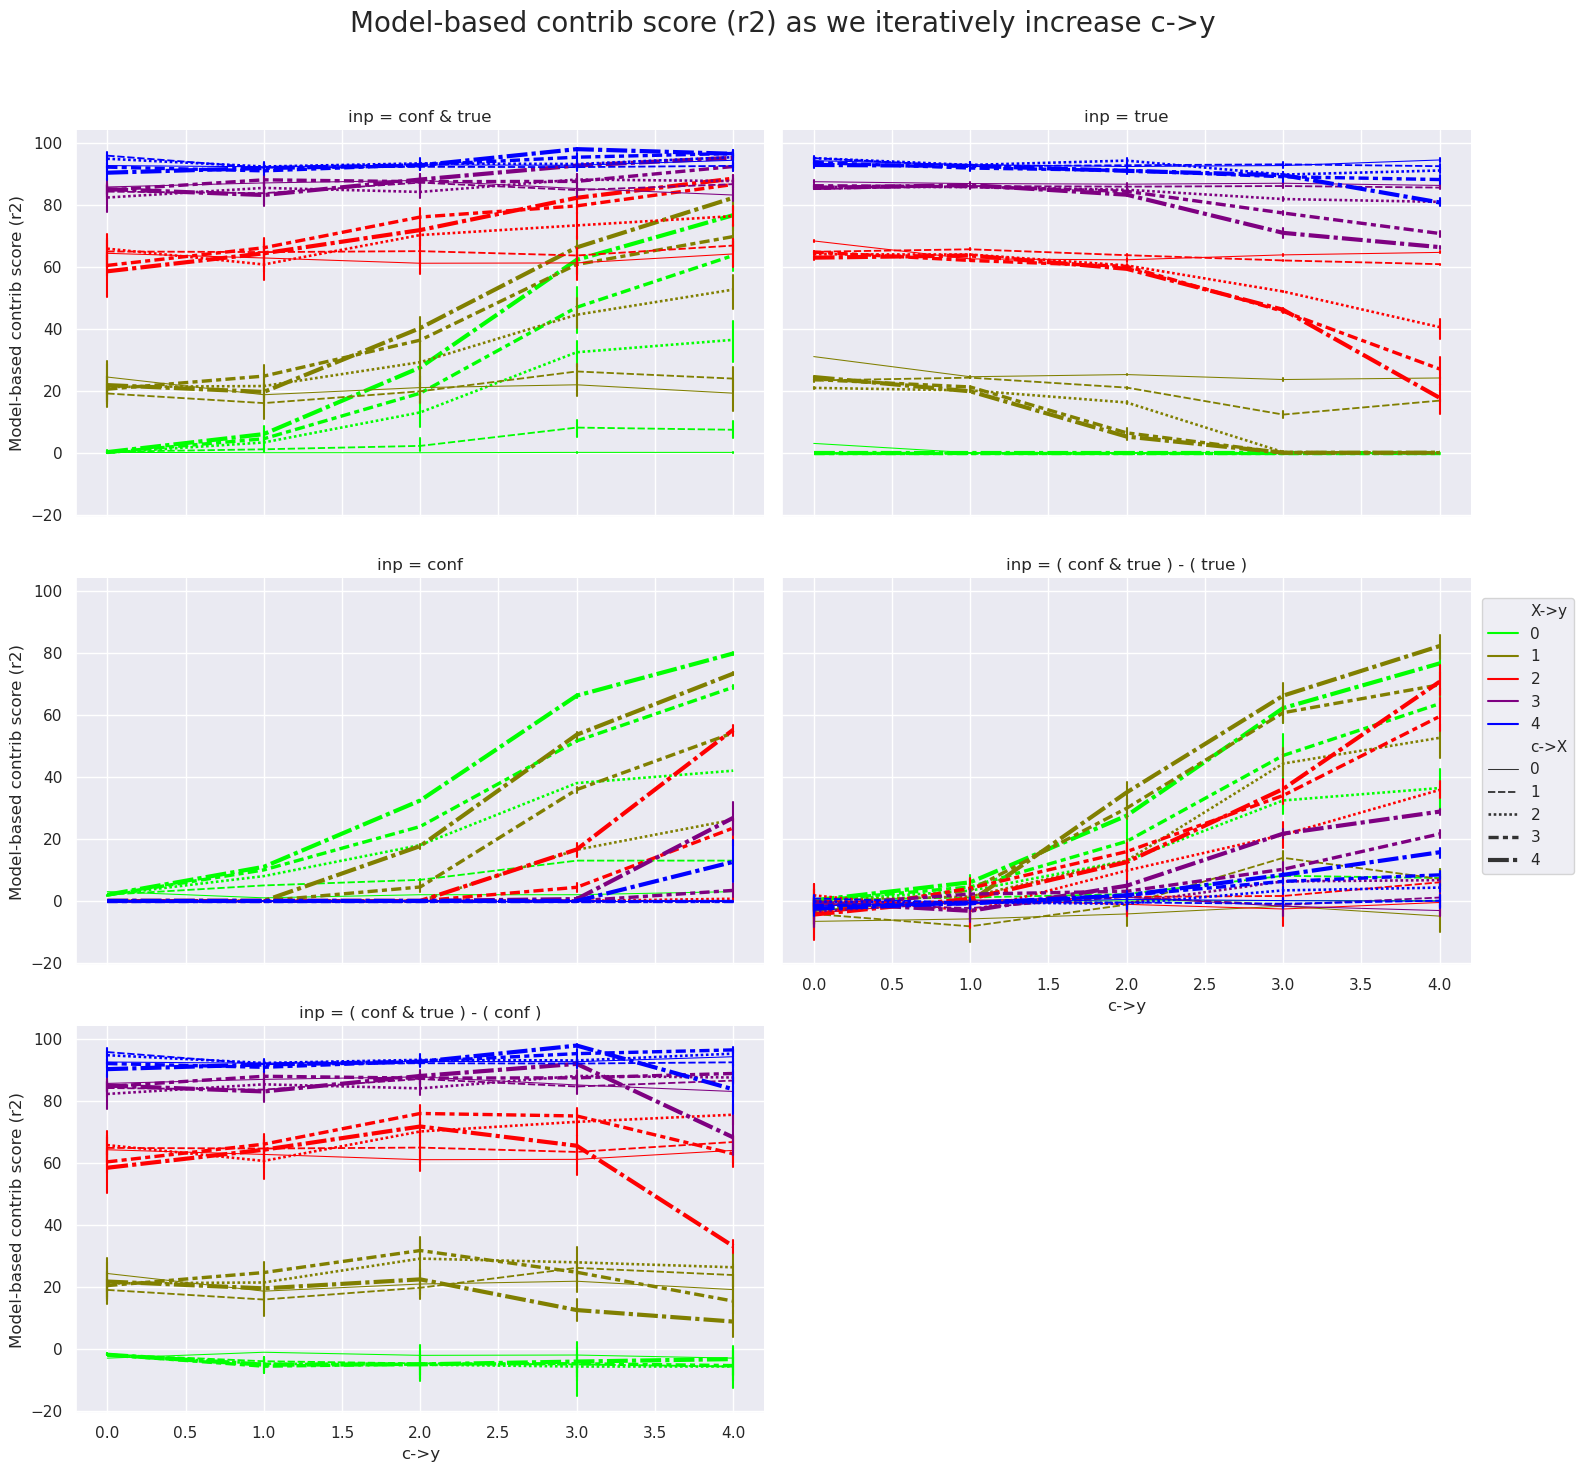

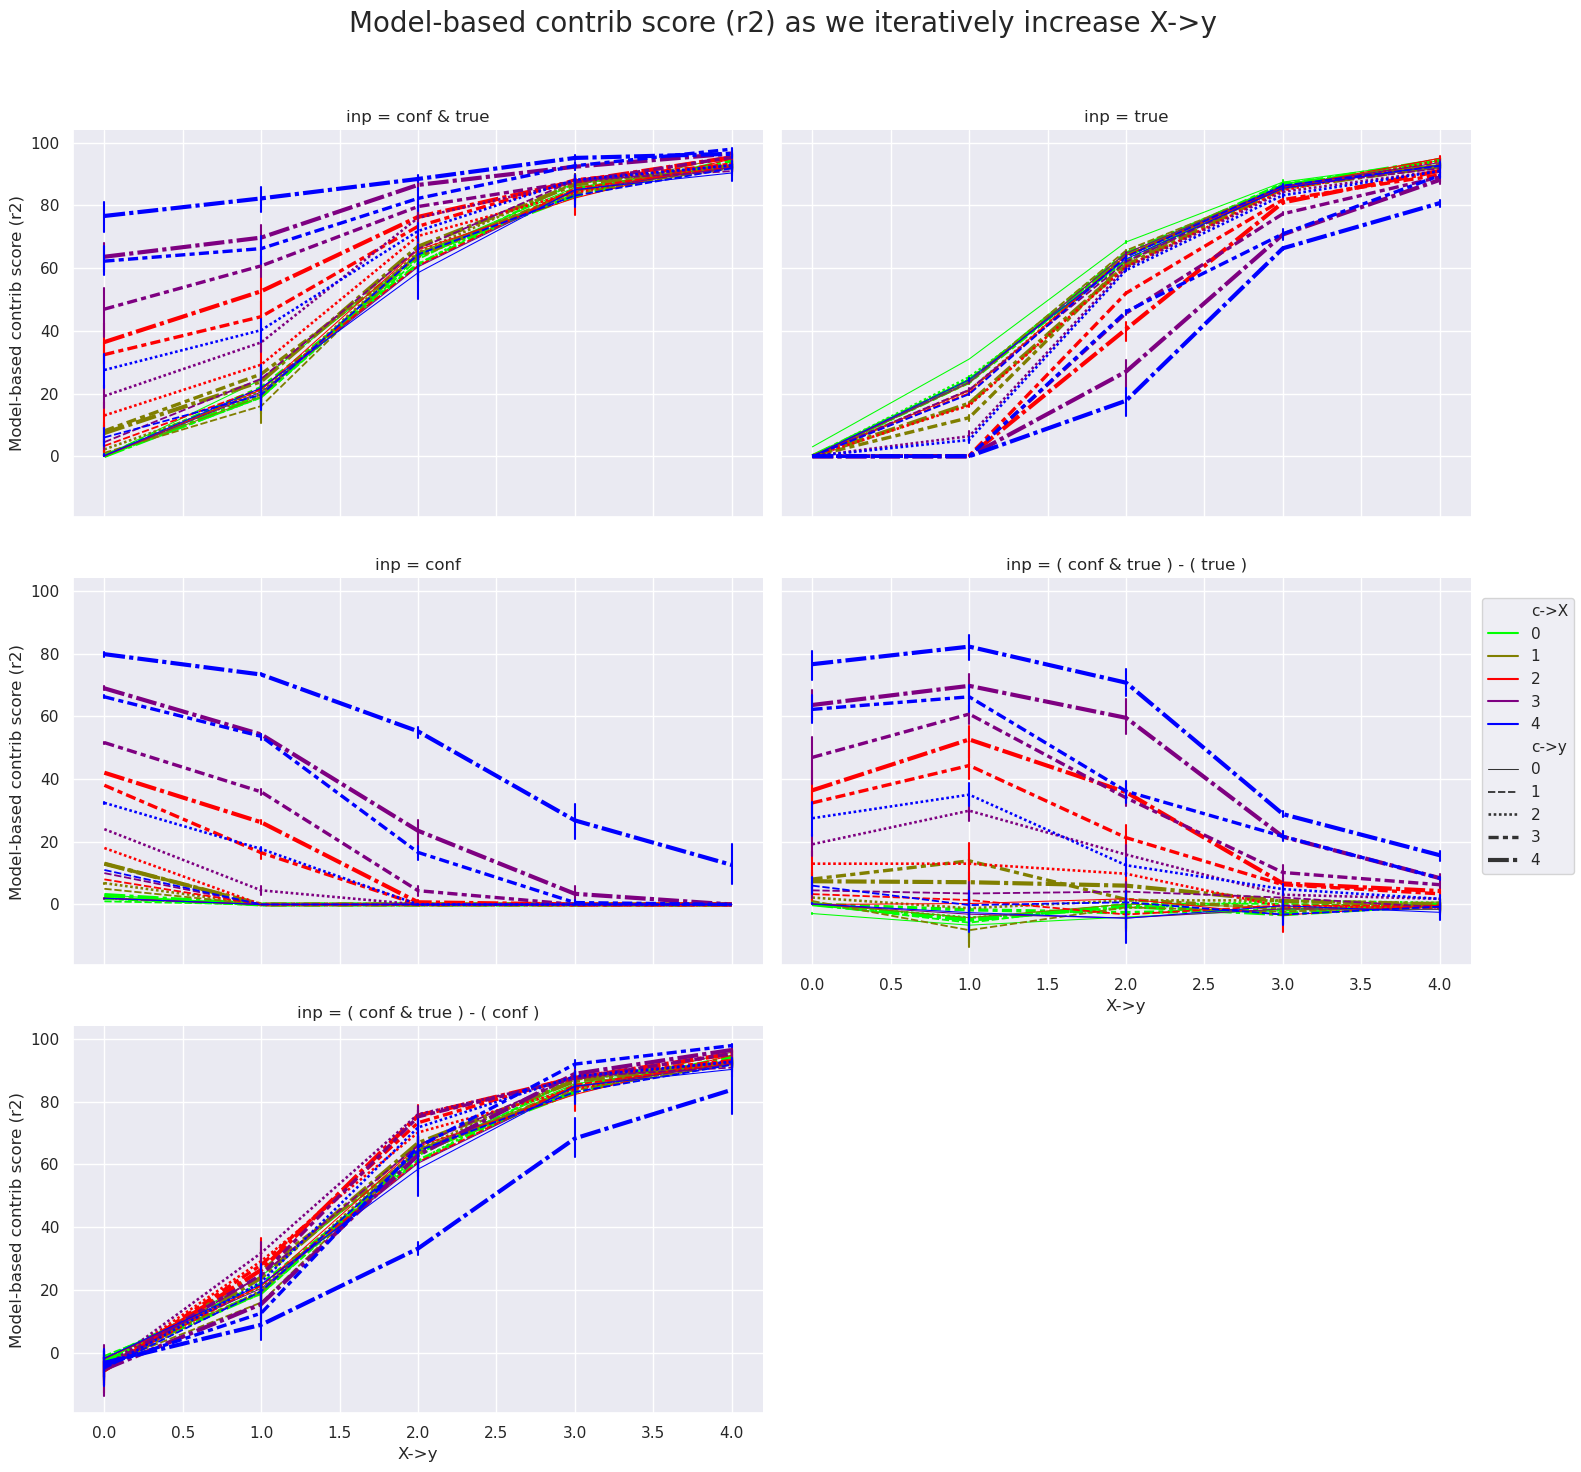

In [159]:
if PLOT_CONTRIB_DECOMPOSED:
    df_decomp_plot = df_decomp.reset_index().drop(columns=['out', 'inp', 'trial']).melt(
        id_vars=['dataset'], var_name='inp', value_name=metric_name)

    viz_contrib_table(df_decomp_plot, X_axes=['c->y','X->y'],
                        metric_col=metric_name,
                        show_SHAP=False, err_style='bars',
                        y_label_suffix=f'({metric_name})')

#### Compare all three contrib scores

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


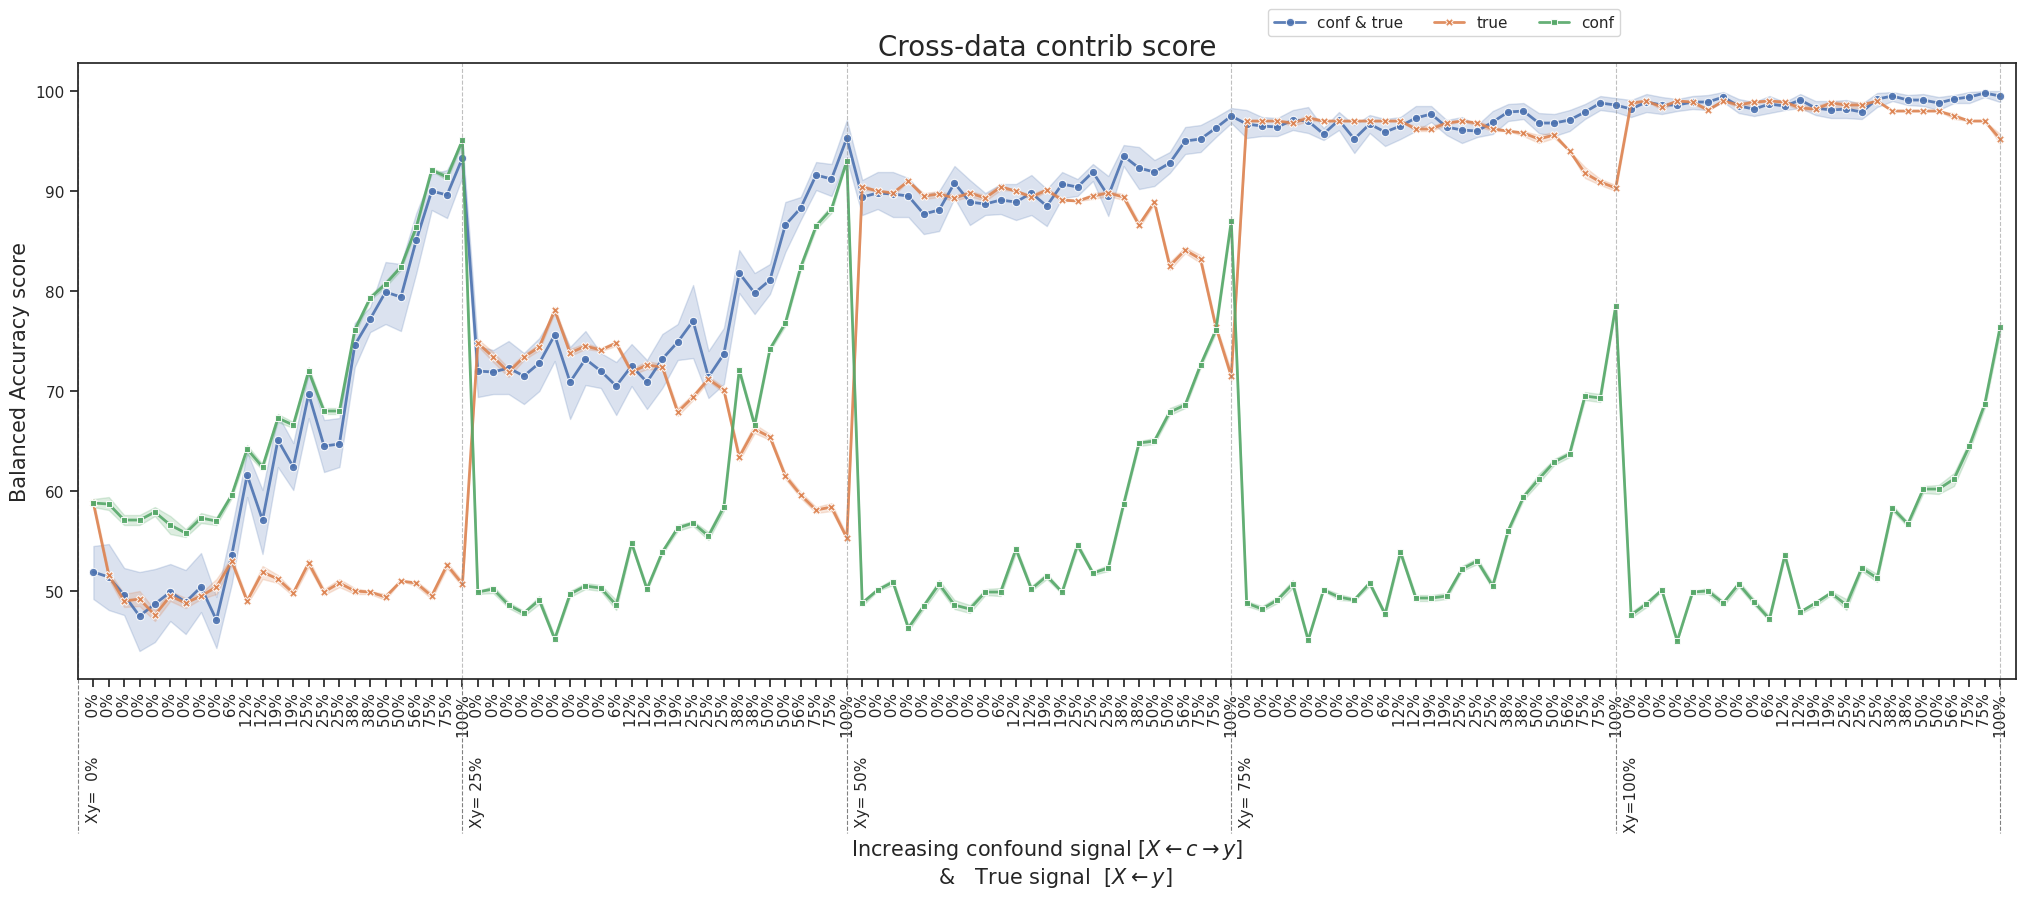

In [151]:
if PLOT_CONTRIB_DECOMPOSED:
    
    df_decomp_plot = df_decomp.reset_index(level=["out", "inp", "trial"], drop=True)
    df_decomp_plot.index = df_decomp_plot.index.map(lambda x: x.split('_')[-1])  # remove the 'dataset' prefix
    df_decomp_plot = df_decomp_plot.drop(columns=['( conf & true ) - ( true )', '( conf & true ) - ( conf )'])

    viz_contrib_table_2(df_decomp_plot, metric_name=metric_name, title='Cross-data contrib score')

All results are shown in percentage (%)


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


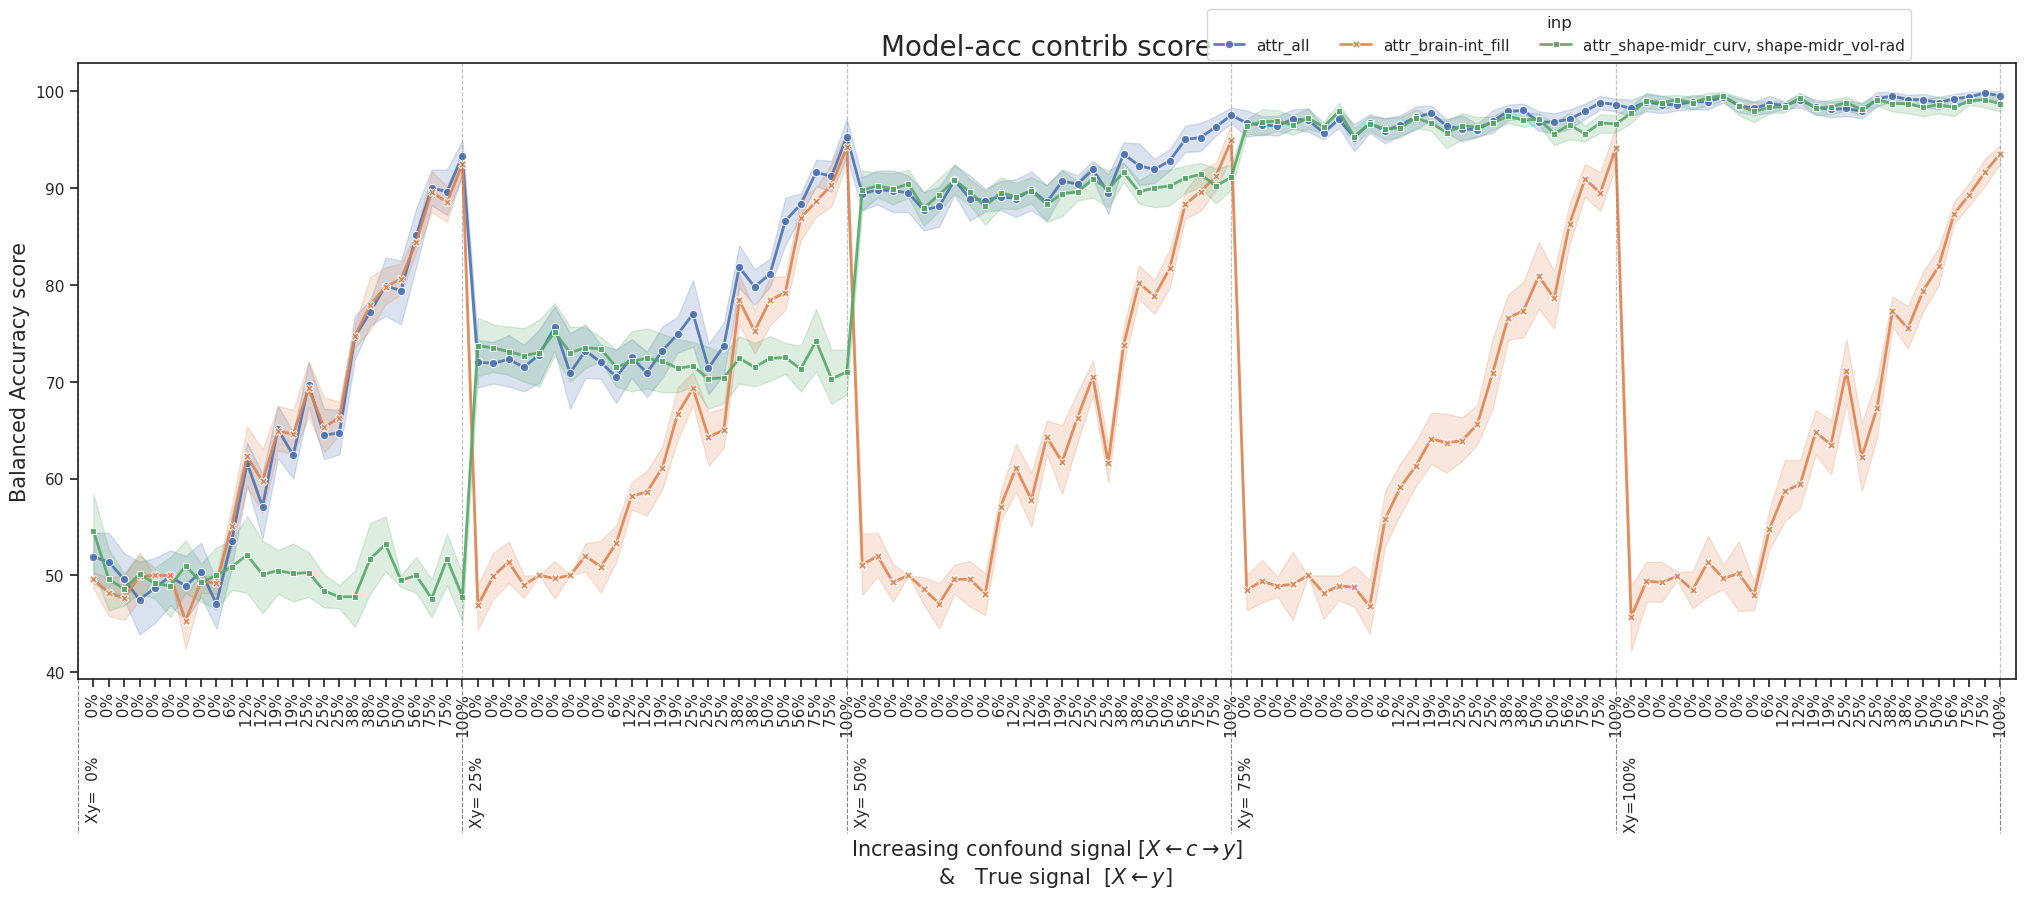

In [154]:
# compare with the SHAP contrib scores
if PLOT_CONTRIB_DECOMPOSED:

    df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion']}, 
                filter_cols=[f'score_test_{metric_name}']
                )
    df_model = df_model.data.unstack(level='inp').reset_index(level=["out", "trial"], drop=True)
    # drop the top level of the column index
    df_model.columns = df_model.columns.droplevel()
    df_model = df_model.drop(columns=['cov_all', 'attr_superset'])
    # df_model = df_model.drop_leve(columns=['score_test_r2'])
    # display(df_model.head())    
    
    
    viz_contrib_table_2(df_model, metric_name=metric_name, title='Model-acc contrib score')
    

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


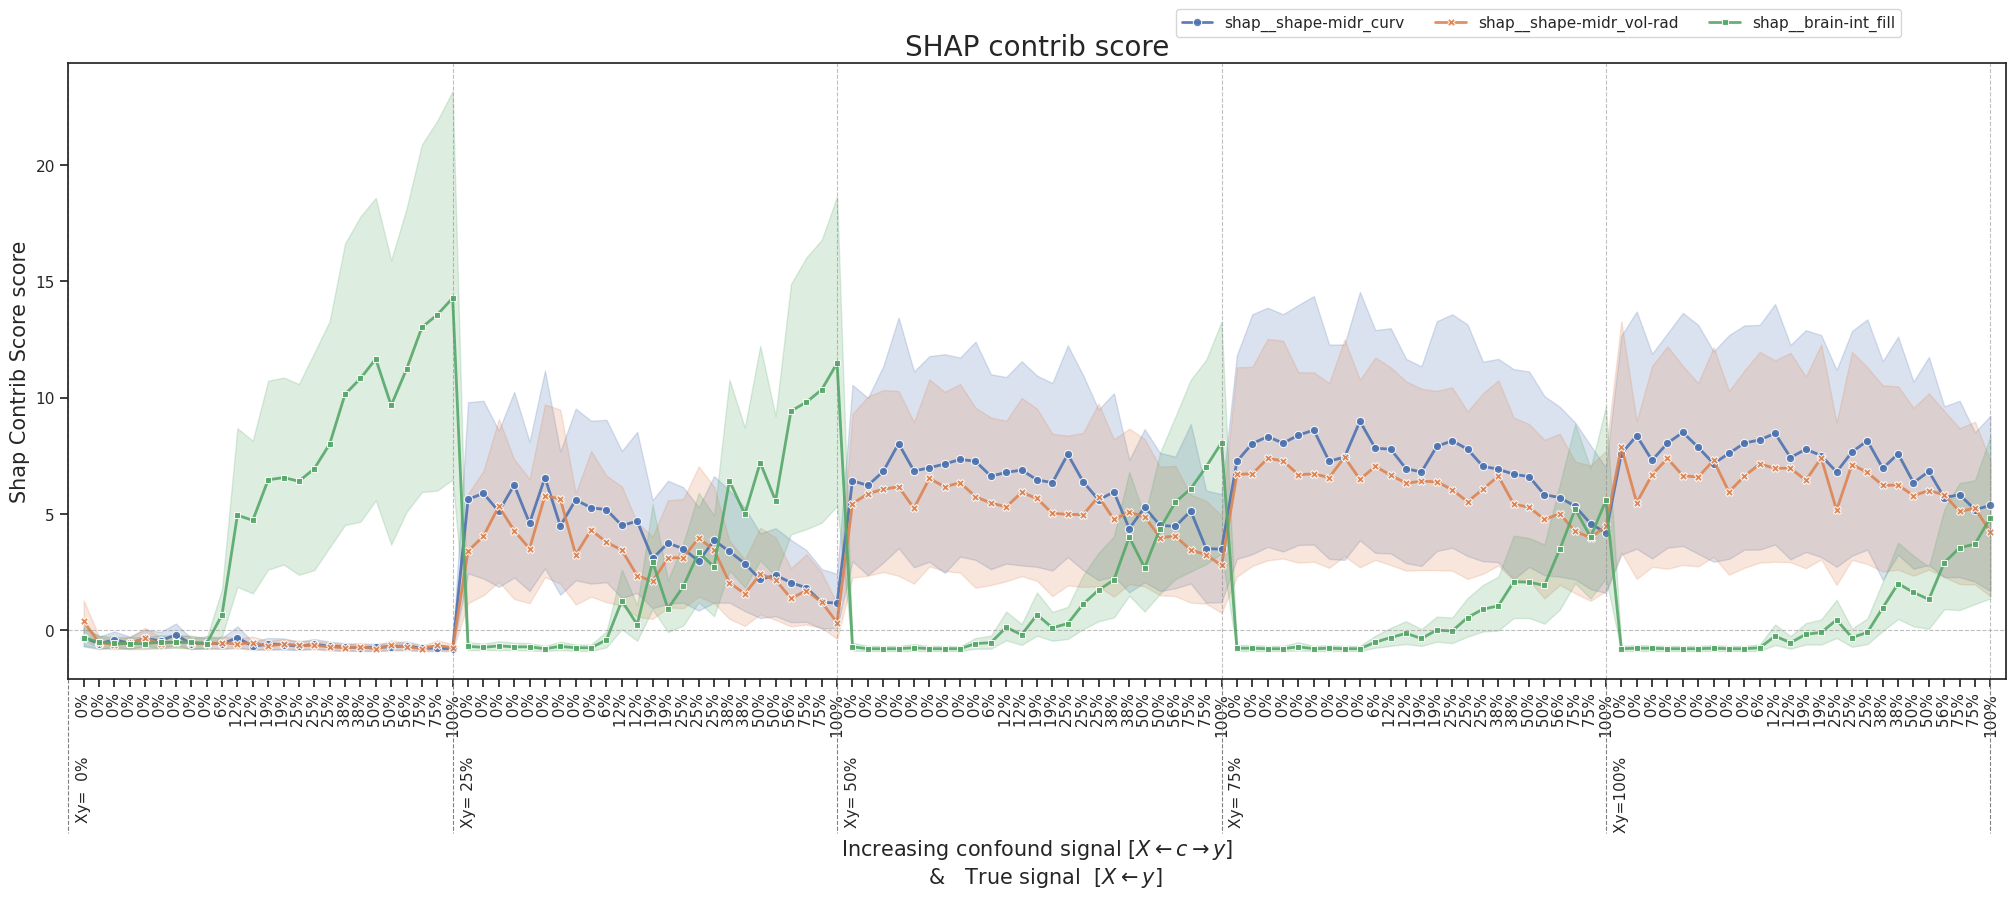

In [155]:
# compare with the SHAP contrib scores
if PLOT_CONTRIB_DECOMPOSED:
    df_shap_2 = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion']}, 
                filter_cols=[f'score_test_{metric_name}']
                )
    df_shap.data.reset_index(level=["out", "inp", "trial"], drop=True)
    df_shap_2 = df_shap_2.drop(columns=['score_test_r2'])
    
    viz_contrib_table_2(df_shap_2, metric_name='SHAP contrib score', title='SHAP contrib score')